In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vincentpssun","key":"d26a8a70aa40ef0a22d3d6e2fd68eab8"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 45.7MB/s]
100% 2.29G/2.29G [00:30<00:00, 82.1MB/s]


In [6]:
! mkdir Pneumonia

In [ ]:
! unzip chest-xray-pneumonia.zip -d Pneumonia

In [8]:
import os, shutil

path_name = './Pneumonia/chest_xray'
dir_length = len(os.listdir(path_name))
os.listdir(path_name)

['test', 'train', 'val', '__MACOSX', 'chest_xray']

In [9]:
train_dir = './Pneumonia/chest_xray/train'
val_dir = './Pneumonia/chest_xray/val'
test_dir = './Pneumonia/chest_xray/test'

print(len(os.listdir(train_dir)), len(os.listdir(val_dir)), len(os.listdir(test_dir)))

2 2 2


In [10]:
print("No. of Normal Training Images: ", len(os.listdir(train_dir+'/NORMAL')), "No of Pneumonia Training Iages: ", len(os.listdir(train_dir+'/PNEUMONIA')))
print("No. of Normal Testing Images: ", len(os.listdir(test_dir+'/NORMAL')), "No of Pneumonia Testing Iages: ", len(os.listdir(test_dir+'/PNEUMONIA')))
print("No. of Normal Validation Images: ", len(os.listdir(val_dir+'/NORMAL')), "No of Pneumonia Validation Iages: ", len(os.listdir(val_dir+'/PNEUMONIA')))

No. of Normal Training Images:  1341 No of Pneumonia Training Iages:  3875
No. of Normal Testing Images:  234 No of Pneumonia Testing Iages:  390
No. of Normal Validation Images:  8 No of Pneumonia Validation Iages:  8


In [11]:
normal_image_count = len(os.listdir(train_dir+'/NORMAL'))
pneumonia_image_count = len(os.listdir(train_dir+'/PNEUMONIA'))
total_image_count = normal_image_count + pneumonia_image_count

In [13]:
import numpy as np # linear algebra
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
weight_for_normal = 1/(normal_image_count/total_image_count)
weight_for_pneumonia = 1/(pneumonia_image_count/total_image_count)
training_weight = {0:weight_for_normal, 1:weight_for_pneumonia}

In [93]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    horizontal_flip=True,
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [94]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=64,
    shuffle=True,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=16,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [108]:
input_layer = tf.keras.Input(shape=(150, 150, 3))
"""
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_tensor=input_layer
)
"""
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=input_layer
)

In [ ]:
base_model.summary()

In [109]:
for layer in base_model.layers:
  layer.trainable = False

In [110]:
"""
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
"""
"""
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
"""
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [111]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [112]:
history = model.fit_generator(
    train_generator,
    epochs=20,
    #class_weight=training_weight,
    validation_data=val_generator,
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
82/82 [==============================] - 70s 847ms/step - loss: 0.5375 - accuracy: 0.7567 - val_loss: 0.6723 - val_accuracy: 0.5000
Epoch 2/20
82/82 [==============================] - 69s 846ms/step - loss: 0.3621 - accuracy: 0.8278 - val_loss: 0.5772 - val_accuracy: 0.5625
Epoch 3/20
82/82 [==============================] - 70s 854ms/step - loss: 0.2837 - accuracy: 0.9022 - val_loss: 0.4964 - val_accuracy: 0.6250
Epoch 4/20
82/82 [==============================] - 69s 846ms/step - loss: 0.2356 - accuracy: 0.9299 - val_loss: 0.4807 - val_accuracy: 0.7500
Epoch 5/20
82/82 [==============================] - 69s 843ms/step - loss: 0.2110 - accuracy: 0.9351 - val_loss: 0.4401 - val_accuracy: 0.8125
Epoch 6/20
82/82 [==============================] - 69s 846ms/step - loss: 0.1886 - accuracy: 0.9432 - val_loss: 0.4220 - val_accuracy: 0.8125
Epoch 7/20
82/82 [==============================] - 69s 841ms/step - loss: 0.1759 - accuracy: 0.9493 - val_loss: 0.4411 - val_accuracy: 0.8125

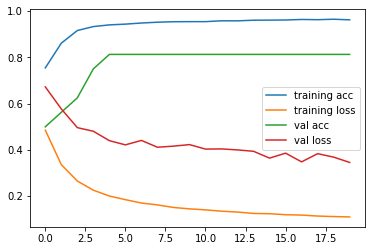

In [113]:
training_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
training_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(training_acc, label='training acc')
plt.plot(training_loss, label='training loss')
plt.plot(val_acc, label='val acc')
plt.plot(val_loss, label='val loss')
plt.legend(loc='best')
plt.show()

In [122]:
eval_result = model.evaluate_generator(test_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [123]:
print('loss: ', eval_result[0])
print('accuracy: ', eval_result[1])

loss:  0.4039112329483032
accuracy:  0.8141025900840759


In [114]:
pred = model.predict_generator(test_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [115]:
pred_new = [1 if p[0] > 0.5 else 0 for p in pred]

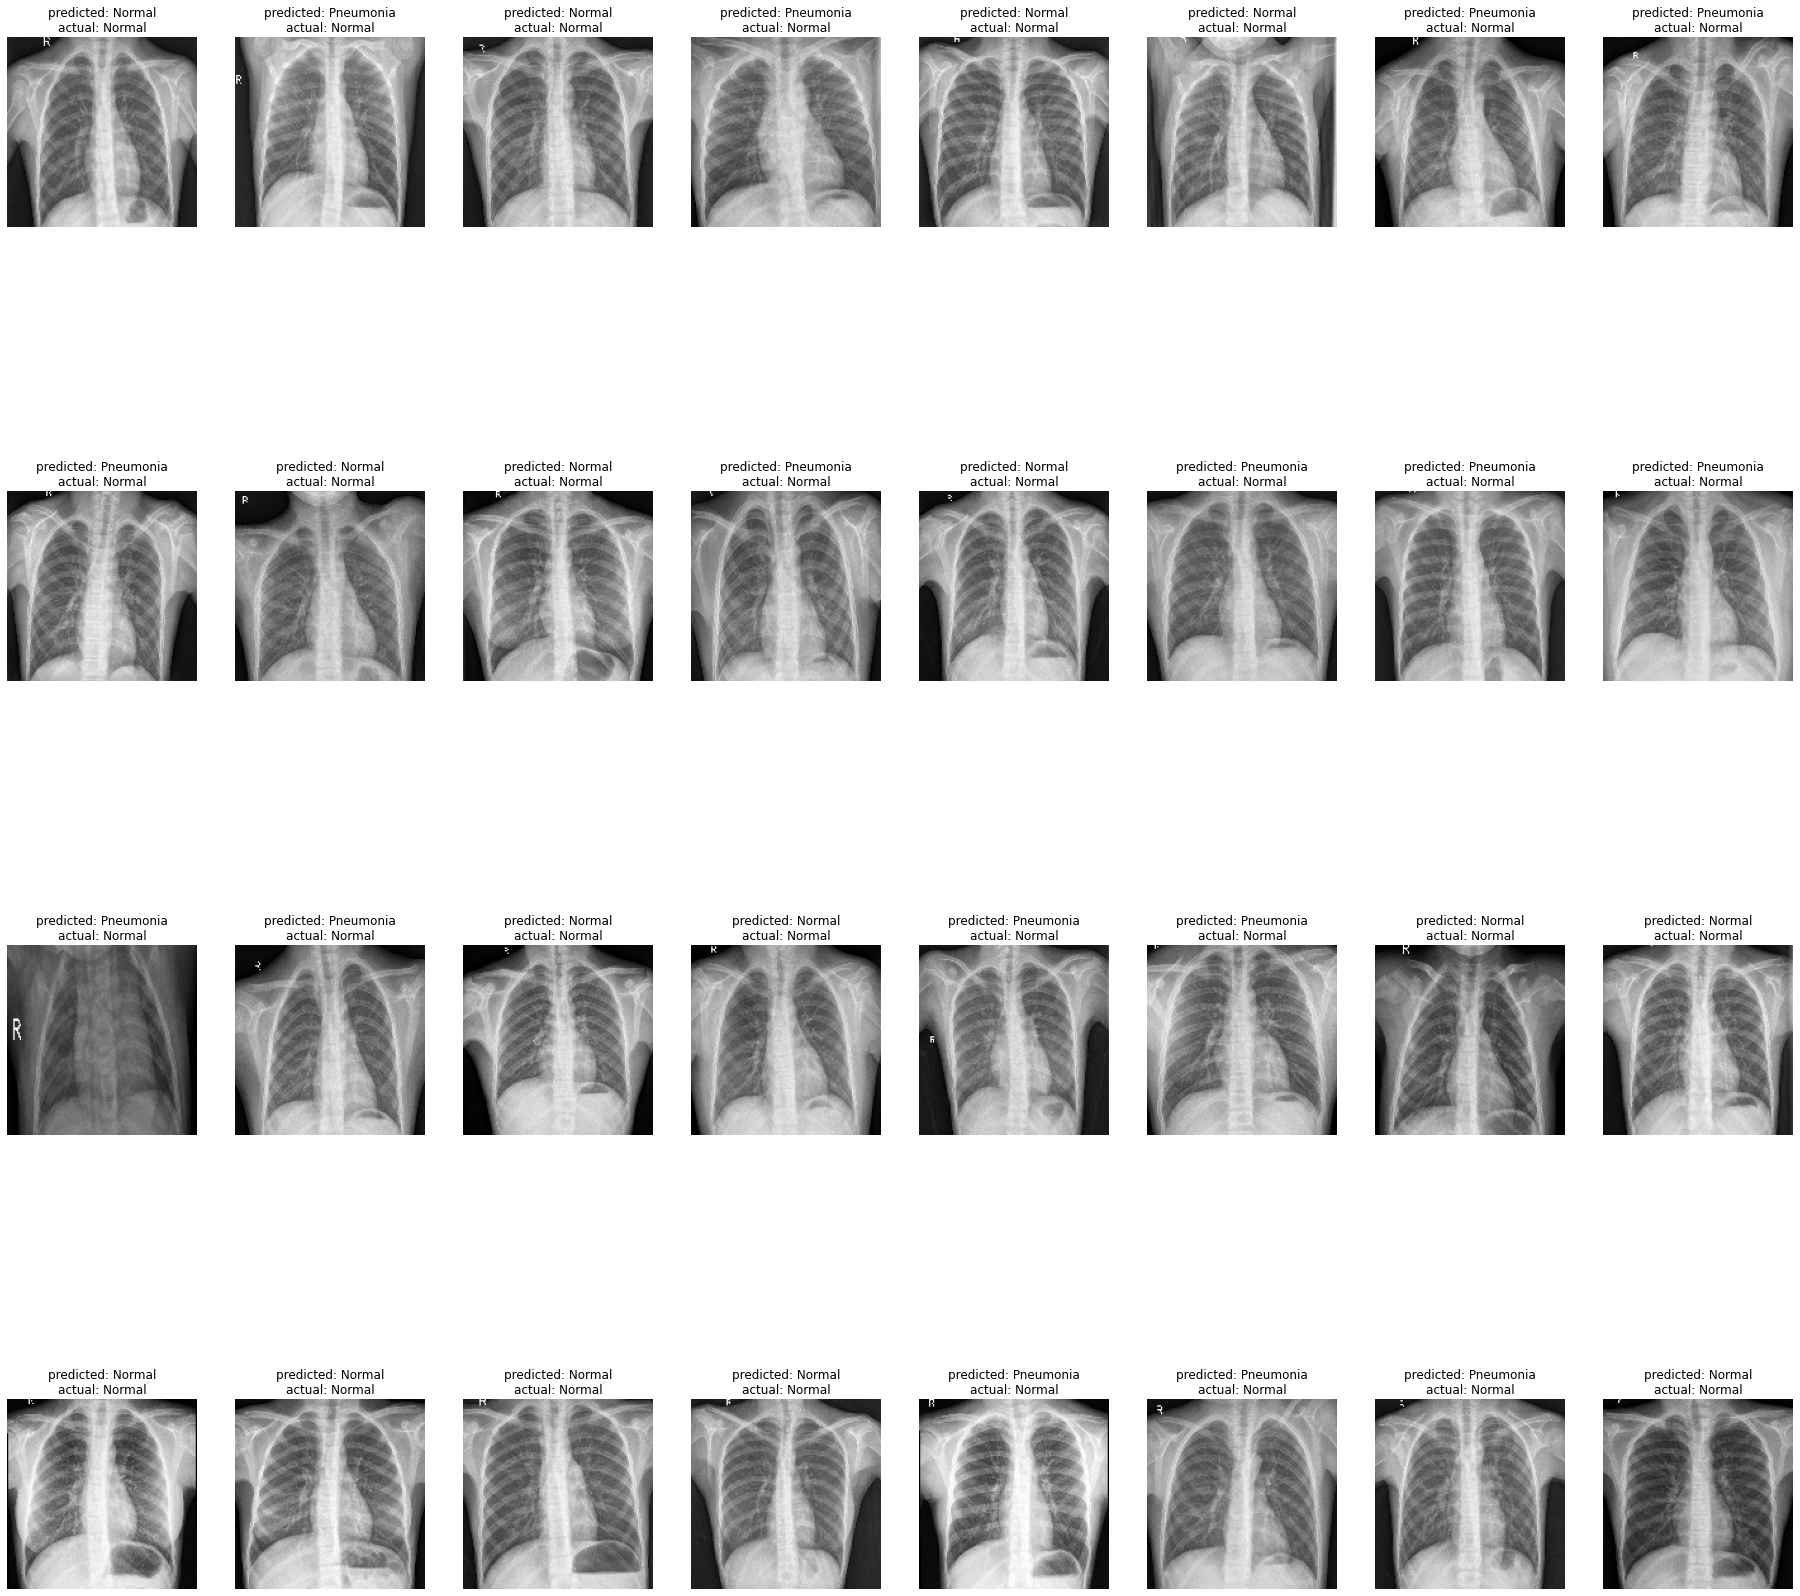

In [121]:
test_generator.reset() # This will make sure we are starting from the beginning
samples, labels = iter(test_generator).next()

fig = plt.figure(figsize=(32,32))
fig.tight_layout()
check = {0:'Normal', 1:'Pneumonia'}

for num, sample in enumerate(samples[:32]):
  plt.subplot(4,8,num+1)
  sub_title = "predicted: "+ check[pred_new[num]] + "\n" + "actual: " + check[labels[num]]
  plt.title(sub_title)
  plt.axis('off')
  plt.imshow(sample)
